# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework.

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training.

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced.

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set.


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters.

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained.

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.


Training model via ReLU:

Baseline - ReLU Activation



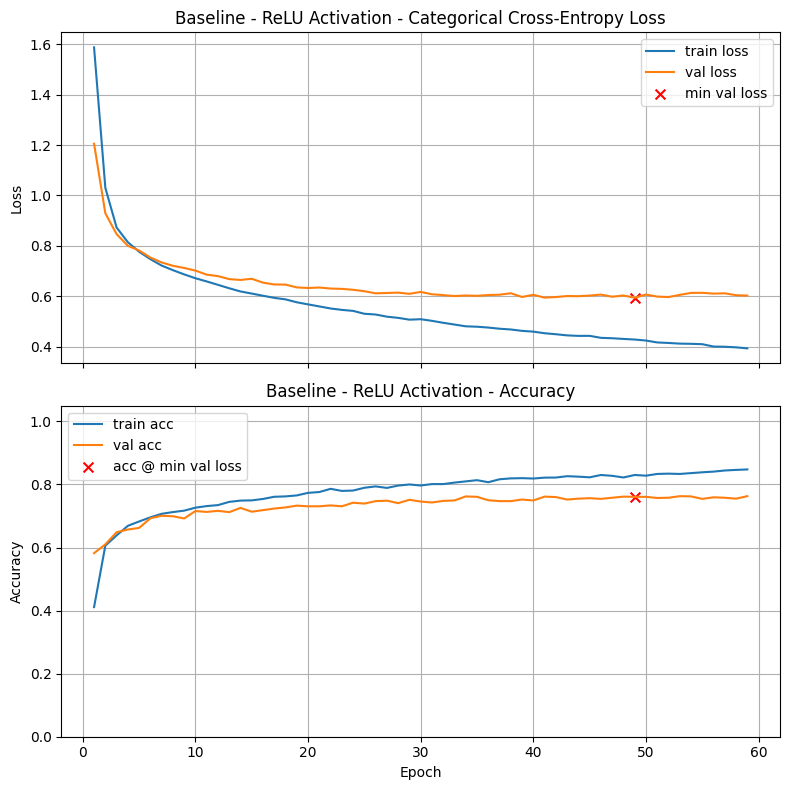

Final Training Loss:            0.3932
Final Training Accuracy:        0.8476
Final Validation Loss:          0.6027
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5943 (Epoch 49)
Validation Accuracy @ Min Loss: 0.7607

Test Loss: 0.6158
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:19


In [9]:
# Your code here. Add as many cells as you need.

# Let's test different activation functions starting with relu, then sigmoid,
# and then tanh with the baseline architecture (64, 32 hidden layers)
print("Training model via ReLU:")
model_relu = build_model(X_train.shape[1], [(64, 'relu', 0.0, 0.0), (32, 'relu', 0.0, 0.0)], n_classes)
train_and_test(model_relu, title="Baseline - ReLU Activation")


Training model via Sigmoid activation:

Baseline - Sigmoid Activation



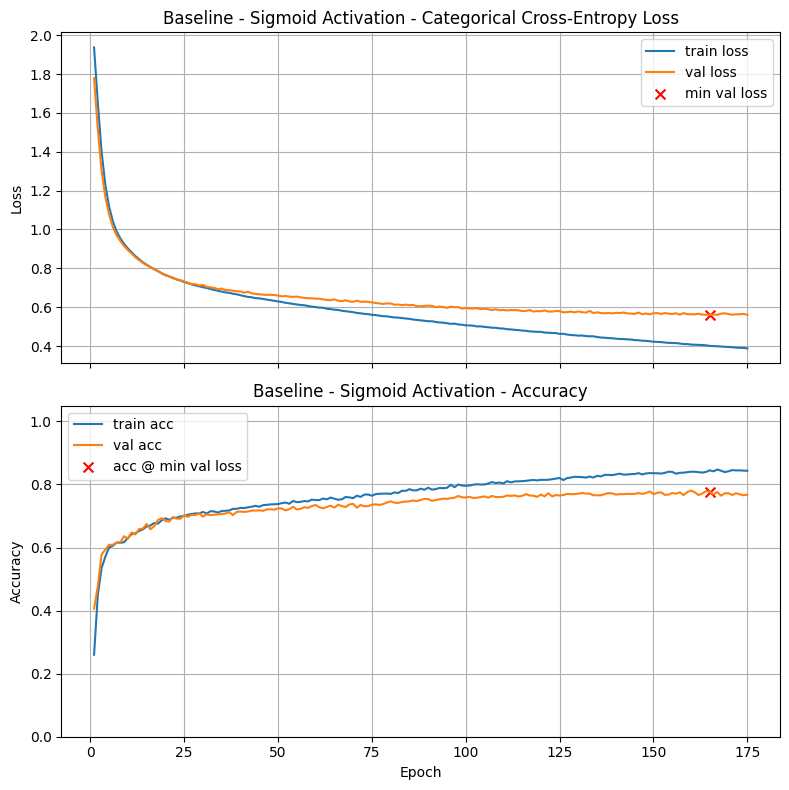

Final Training Loss:            0.3878
Final Training Accuracy:        0.8433
Final Validation Loss:          0.5607
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5604 (Epoch 165)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.5768
Test Accuracy: 0.7621

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:56


In [10]:
# Test Sigmoid activation
print("Training model via Sigmoid activation:")
model_sigmoid = build_model(X_train.shape[1], [(64, 'sigmoid', 0.0, 0.0), (32, 'sigmoid', 0.0, 0.0)], n_classes)
train_and_test(model_sigmoid, title="Baseline - Sigmoid Activation")

Training model with Tanh activation:

Baseline - Tanh Activation



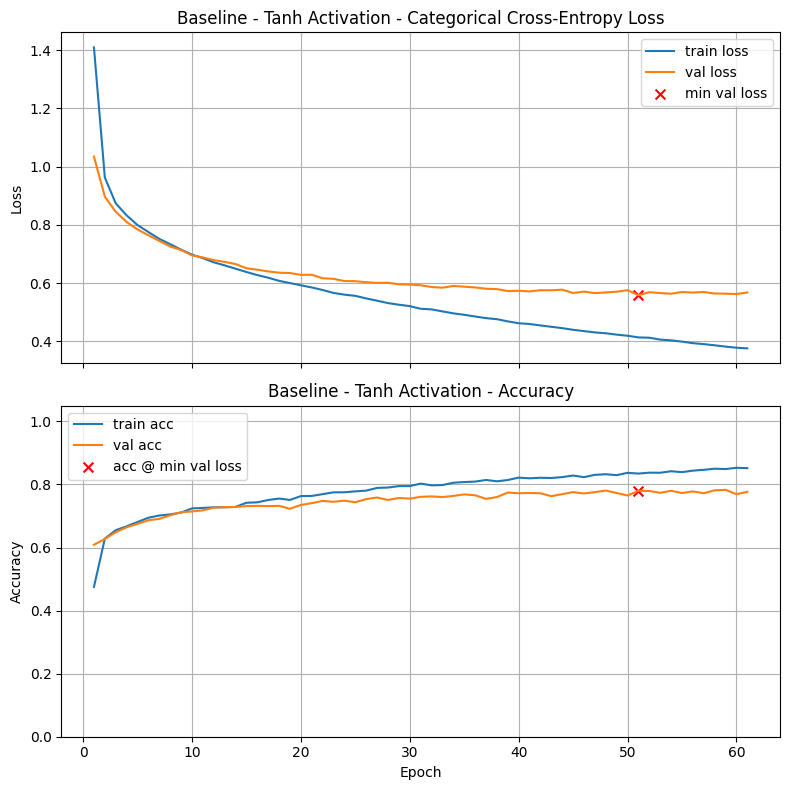

Final Training Loss:            0.3761
Final Training Accuracy:        0.8517
Final Validation Loss:          0.5680
Final Validation Accuracy:      0.7764
Minimum Validation Loss:        0.5588 (Epoch 51)
Validation Accuracy @ Min Loss: 0.7800

Test Loss: 0.5721
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:22


In [11]:
# Test Tanh activation
print("Training model with Tanh activation:")
model_tanh = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
train_and_test(model_tanh, title="Baseline - Tanh Activation")

### Graded Questions

In [12]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [13]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 2


In [14]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7800             # Replace 0.0 with your answer

In [15]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.7800


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**


In [16]:
# Your code here. Add as many cells as you need.
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

Training model with learning rate 1e-3:

LR 1e-3 - Tanh Activation



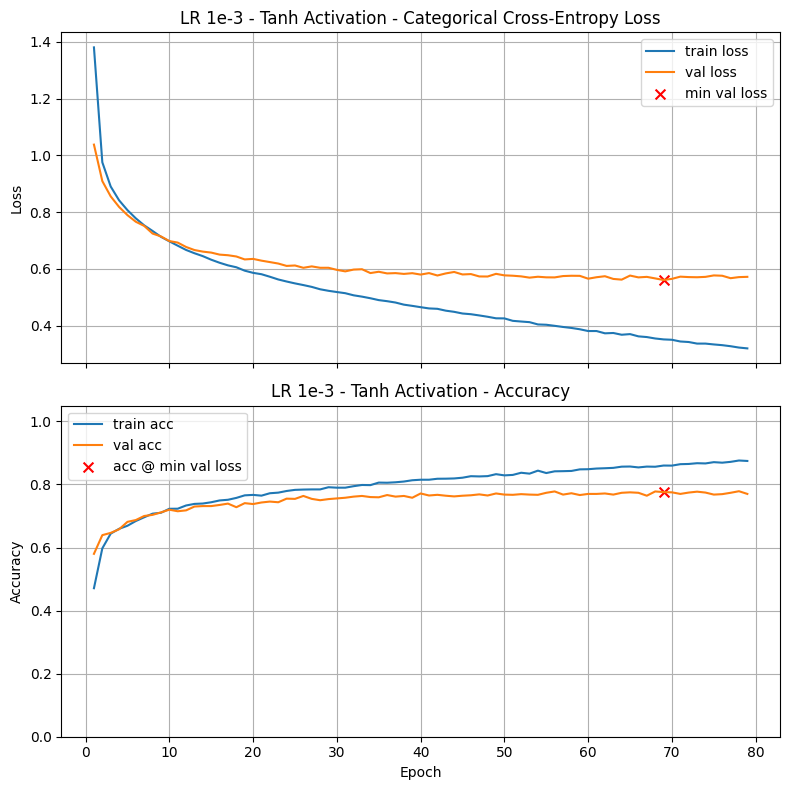

Final Training Loss:            0.3197
Final Training Accuracy:        0.8745
Final Validation Loss:          0.5718
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.5606 (Epoch 69)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.5925
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.020000

Execution Time: 00:00:28


In [17]:
# Test learning rate 1e-3
print("Training model with learning rate 1e-3:")
model_lr1 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
train_and_test(model_lr1, lr_schedule=1e-3, title="LR 1e-3 - Tanh Activation")

Training model with learning rate 5e-4:

LR 5e-4 - Tanh Activation



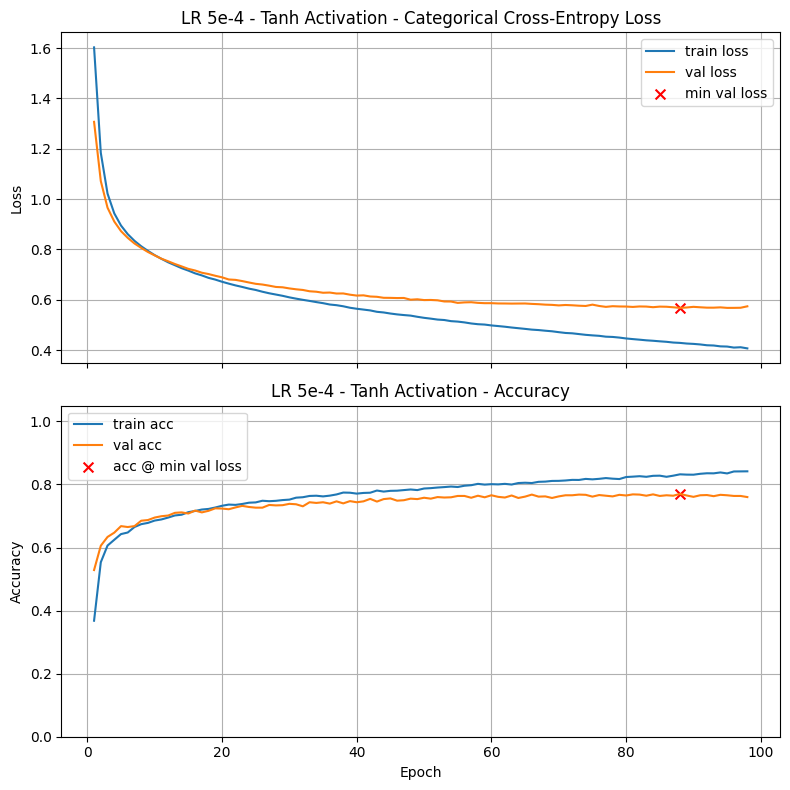

Final Training Loss:            0.4068
Final Training Accuracy:        0.8417
Final Validation Loss:          0.5740
Final Validation Accuracy:      0.7600
Minimum Validation Loss:        0.5677 (Epoch 88)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5762
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:31


In [18]:
# Test learning rate 5e-4
print("Training model with learning rate 5e-4:")
model_lr2 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
train_and_test(model_lr2, lr_schedule=5e-4, title="LR 5e-4 - Tanh Activation")

Training model with learning rate 1e-4:

LR 1e-4 - Tanh Activation



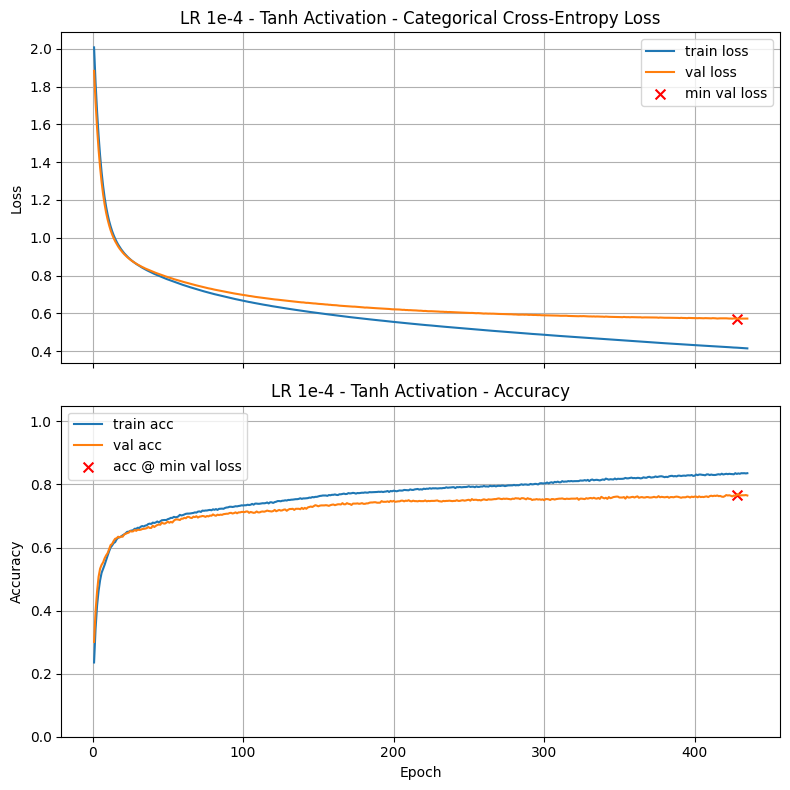

Final Training Loss:            0.4148
Final Training Accuracy:        0.8357
Final Validation Loss:          0.5725
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.5721 (Epoch 428)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.5860
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:02:20


In [19]:
# Test learning rate 1e-4
print("Training model with learning rate 1e-4:")
model_lr3 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
train_and_test(model_lr3, lr_schedule=1e-4, title="LR 1e-4 - Tanh Activation")

Training model with learning rate 5e-5:

LR 5e-5 - Tanh Activation



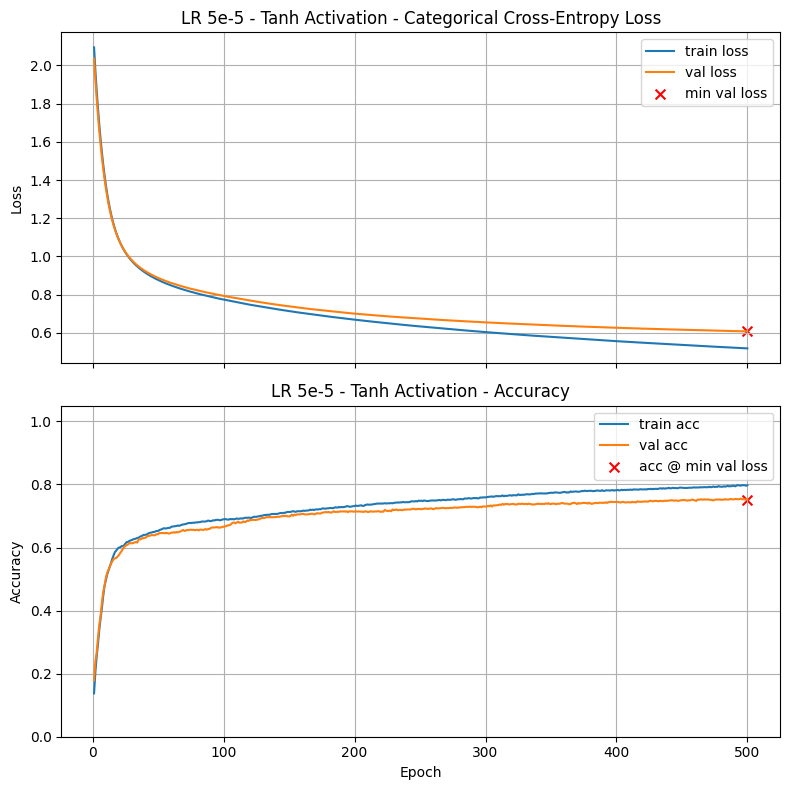

Final Training Loss:            0.5192
Final Training Accuracy:        0.7974
Final Validation Loss:          0.6079
Final Validation Accuracy:      0.7514
Minimum Validation Loss:        0.6079 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7514

Test Loss: 0.6236
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:02:36


In [20]:
# Test learning rate 5e-5
print("Training model with learning rate 5e-5:")
model_lr4 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
train_and_test(model_lr4, lr_schedule=5e-5, title="LR 5e-5 - Tanh Activation")

Training model with learning rate 1e-5:

LR 1e-5 - Tanh Activation



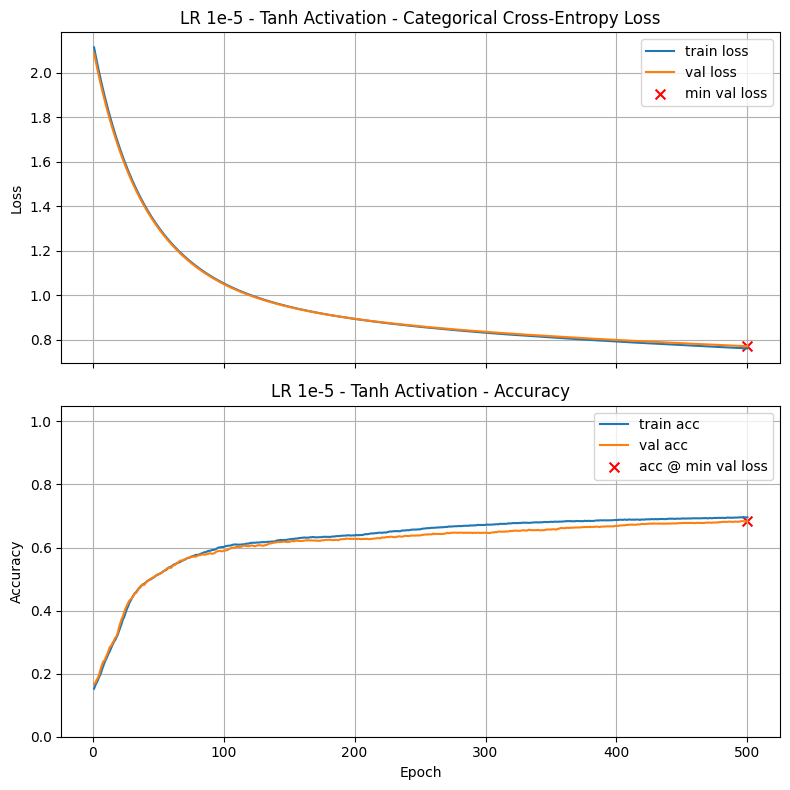

Final Training Loss:            0.7621
Final Training Accuracy:        0.6962
Final Validation Loss:          0.7720
Final Validation Accuracy:      0.6836
Minimum Validation Loss:        0.7720 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6836

Test Loss: 0.7887
Test Accuracy: 0.7021

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:02:40


In [21]:
# Test learning rate 1e-5
print("Training model with learning rate 1e-5:")
model_lr5 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
train_and_test(model_lr5, lr_schedule=1e-5, title="LR 1e-5 - Tanh Activation")

#### Graded Questions

In [22]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 1e-3           # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.6f}')

a2a = 0.001000


In [24]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7757             # Replace 0.0 with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7757


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.


Testing dropout combination (0.0, 0.0):

Dropout (0.0, 0.0) - Baseline



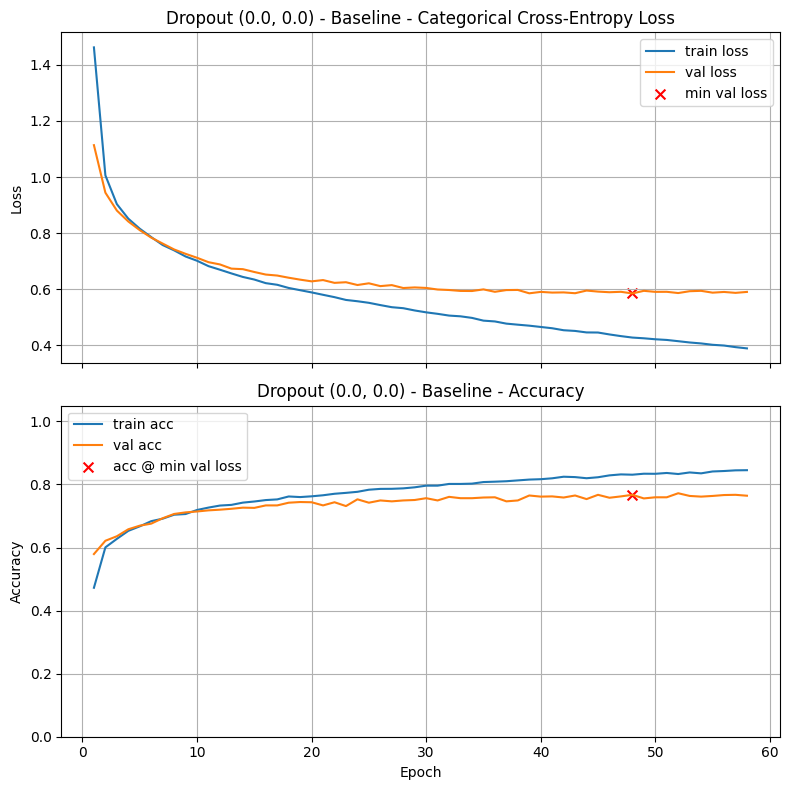

Final Training Loss:            0.3893
Final Training Accuracy:        0.8452
Final Validation Loss:          0.5906
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.5851 (Epoch 48)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.5816
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:20


In [26]:
# Your code here. Add as many cells as you need.

# We are now testing dropout combinations

# Using tanh activation and learning rate 1e-3 (best from the previous problems)
# Testing strategic dropout combinations based on the guidelines

# Test 1: No dropout (baseline)
print("Testing dropout combination (0.0, 0.0):")
model_drop1 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
train_and_test(model_drop1, lr_schedule=1e-3, title="Dropout (0.0, 0.0) - Baseline")


Testing dropout combination (0.0, 0.3):

Dropout (0.0, 0.3)



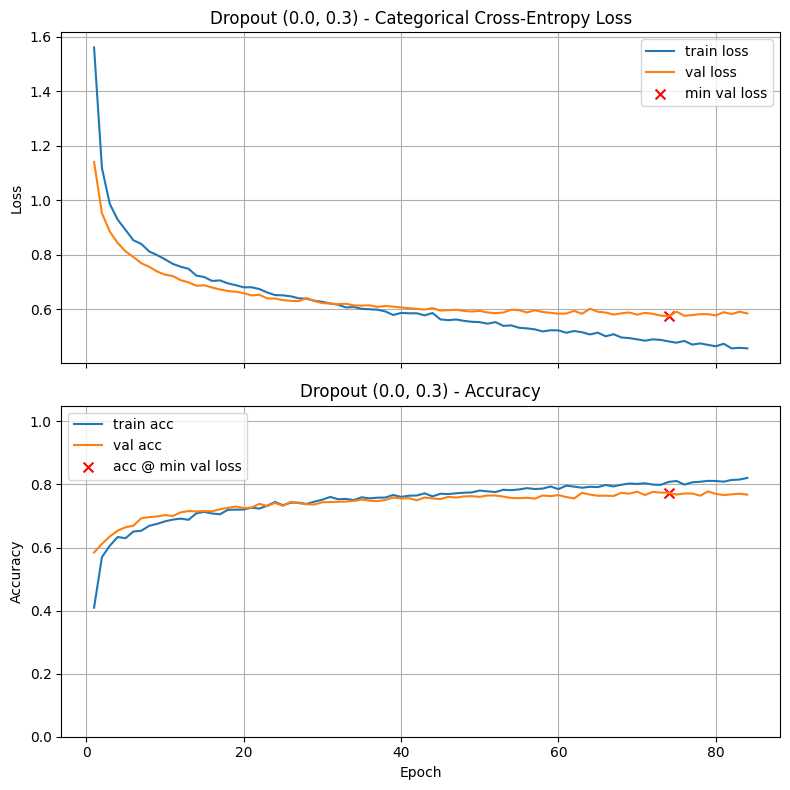

Final Training Loss:            0.4560
Final Training Accuracy:        0.8207
Final Validation Loss:          0.5840
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5738 (Epoch 74)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.5929
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:27


In [27]:
# Test 2: Small dropout on second layer only
print("Testing dropout combination (0.0, 0.3):")
model_drop2 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.3)], n_classes)
train_and_test(model_drop2, lr_schedule=1e-3, title="Dropout (0.0, 0.3)")

Testing dropout combination (0.0, 0.4):

Dropout (0.0, 0.4)



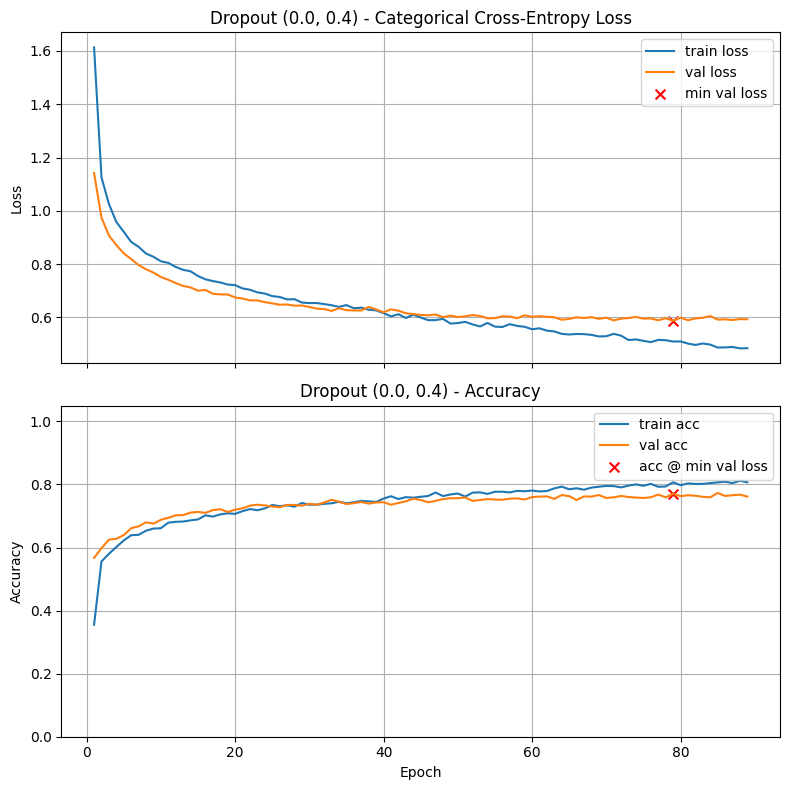

Final Training Loss:            0.4845
Final Training Accuracy:        0.8069
Final Validation Loss:          0.5931
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.5872 (Epoch 79)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.6143
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:31


In [28]:
# Test 3: Higher dropout on second layer
print("Testing dropout combination (0.0, 0.4):")
model_drop3 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.4)], n_classes)
train_and_test(model_drop3, lr_schedule=1e-3, title="Dropout (0.0, 0.4)")

Testing dropout combination (0.1, 0.3):

Dropout (0.1, 0.3)



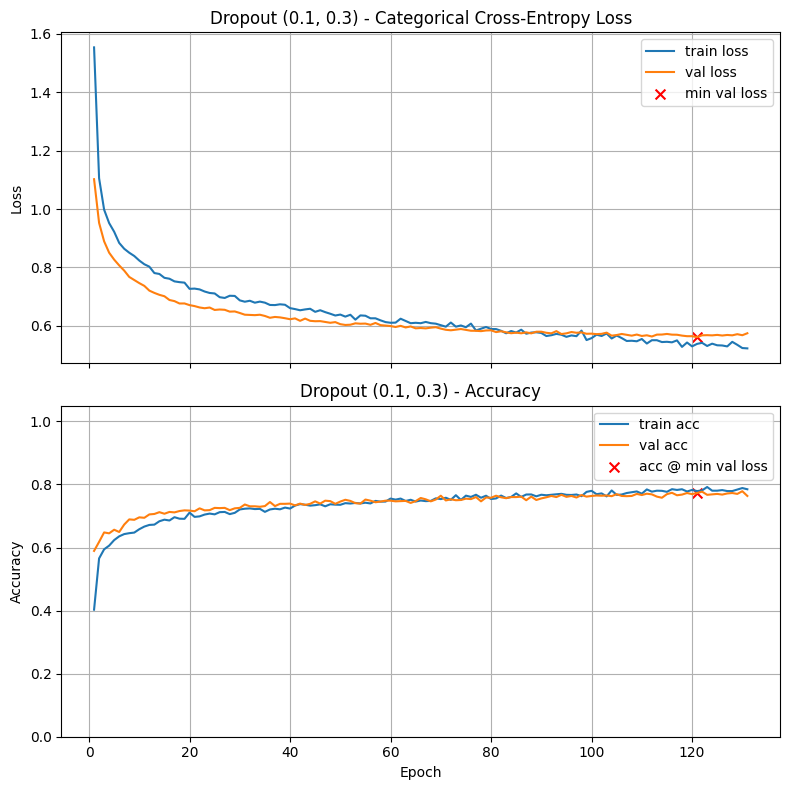

Final Training Loss:            0.5231
Final Training Accuracy:        0.7848
Final Validation Loss:          0.5749
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.5618 (Epoch 121)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.5770
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:43


In [29]:
# Test 4: Small dropout on first layer, moderate on second
print("Testing dropout combination (0.1, 0.3):")
model_drop4 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.1), (32, 'tanh', 0.0, 0.3)], n_classes)
train_and_test(model_drop4, lr_schedule=1e-3, title="Dropout (0.1, 0.3)")

Testing dropout combination (0.0, 0.5):

Dropout (0.0, 0.5)



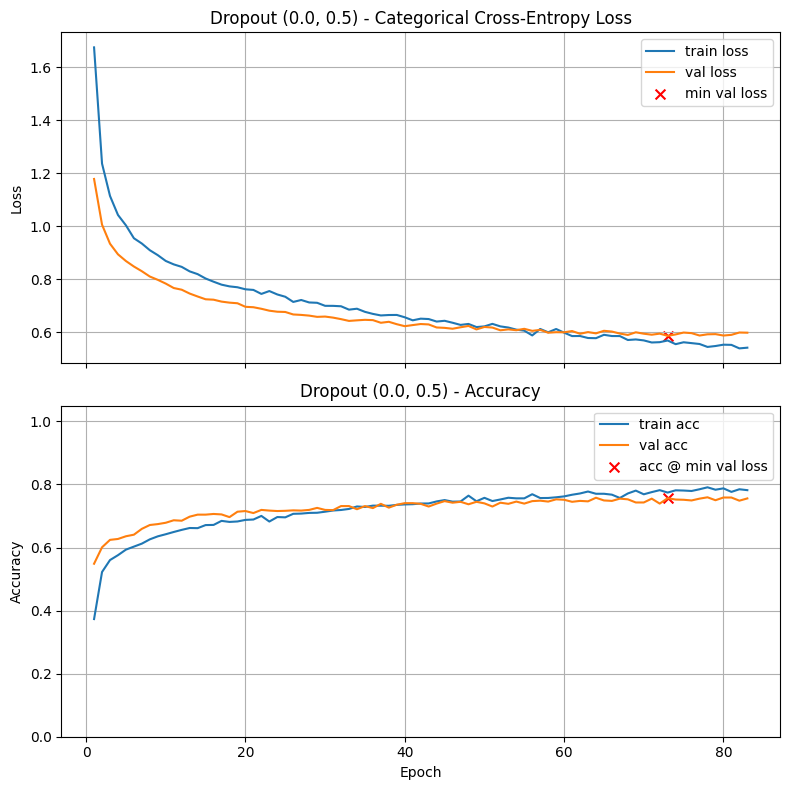

Final Training Loss:            0.5427
Final Training Accuracy:        0.7819
Final Validation Loss:          0.5991
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.5873 (Epoch 73)
Validation Accuracy @ Min Loss: 0.7564

Test Loss: 0.6105
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:29


In [30]:
# Test 5: Higher dropout on second layer only (0.5)
print("Testing dropout combination (0.0, 0.5):")
model_drop5 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.5)], n_classes)
train_and_test(model_drop5, lr_schedule=1e-3, title="Dropout (0.0, 0.5)")

Testing dropout combination (0.2, 0.3):

Dropout (0.2, 0.3)



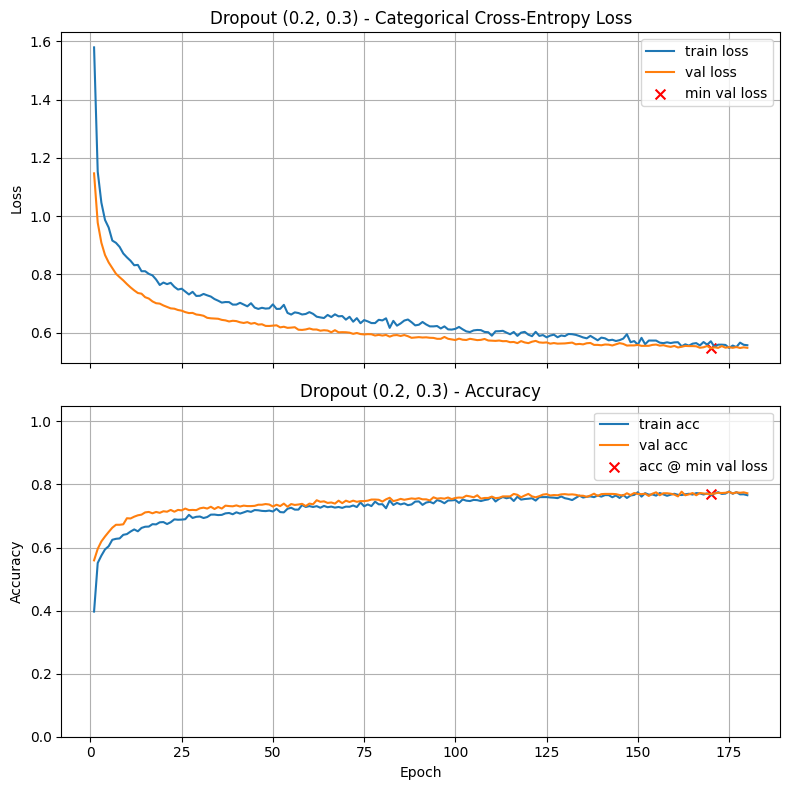

Final Training Loss:            0.5569
Final Training Accuracy:        0.7660
Final Validation Loss:          0.5480
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.5460 (Epoch 170)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.5922
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:57


In [31]:
# Test 6: Small dropout on first layer, higher on second
print("Testing dropout combination (0.2, 0.3):")
model_drop6 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.2), (32, 'tanh', 0.0, 0.3)], n_classes)
train_and_test(model_drop6, lr_schedule=1e-3, title="Dropout (0.2, 0.3)")

In [32]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best
# validation accuracy at the epoch of minimum validation loss

a3a = (0.0, 0.3)             # Replace (0.0,0.0) with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')

a3a = (0.0, 0.3)


In [34]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.7736             # Replace 0.0 with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.7736


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.


Testing L2 regularization (0.0, 0.0) - No regularization:

L2 (0.0, 0.0) - No Regularization



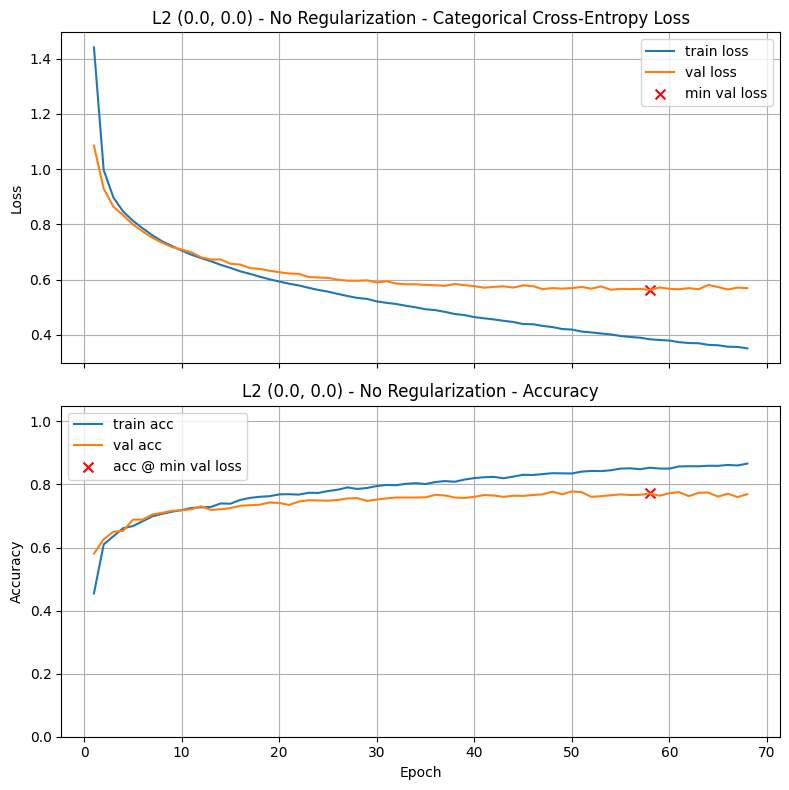

Final Training Loss:            0.3510
Final Training Accuracy:        0.8662
Final Validation Loss:          0.5691
Final Validation Accuracy:      0.7693
Minimum Validation Loss:        0.5622 (Epoch 58)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.5827
Test Accuracy: 0.7650

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:22


In [36]:
# Your code here. Add as many cells as you need.
# Problem 4 - we are testing L2 regularization using tanh activation, learning rate 1e-3, and no dropout
# Testing L2 lambda values: 1e-4, 1e-3, 1e-2

# Test 1: No L2 regularization (baseline)
print("Testing L2 regularization (0.0, 0.0) - No regularization:")
model_l2_1 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
train_and_test(model_l2_1, lr_schedule=1e-3, title="L2 (0.0, 0.0) - No Regularization")

Testing L2 regularization (1e-4, 1e-4):

L2 (1e-4, 1e-4)



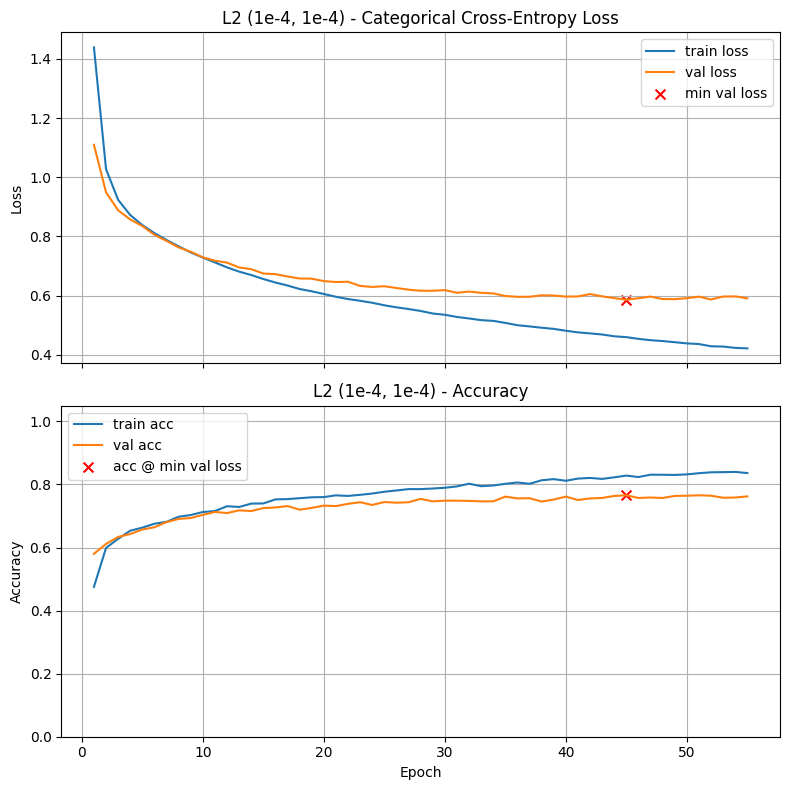

Final Training Loss:            0.4220
Final Training Accuracy:        0.8362
Final Validation Loss:          0.5911
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.5865 (Epoch 45)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.5968
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:00:20


In [37]:
# Test 2: Same L2 lambda (1e-4) in both layers
print("Testing L2 regularization (1e-4, 1e-4):")
model_l2_2 = build_model(X_train.shape[1], [(64, 'tanh', 1e-4, 0.0), (32, 'tanh', 1e-4, 0.0)], n_classes)
train_and_test(model_l2_2, lr_schedule=1e-3, title="L2 (1e-4, 1e-4)")

Testing L2 regularization (1e-3, 1e-3):

L2 (1e-3, 1e-3)



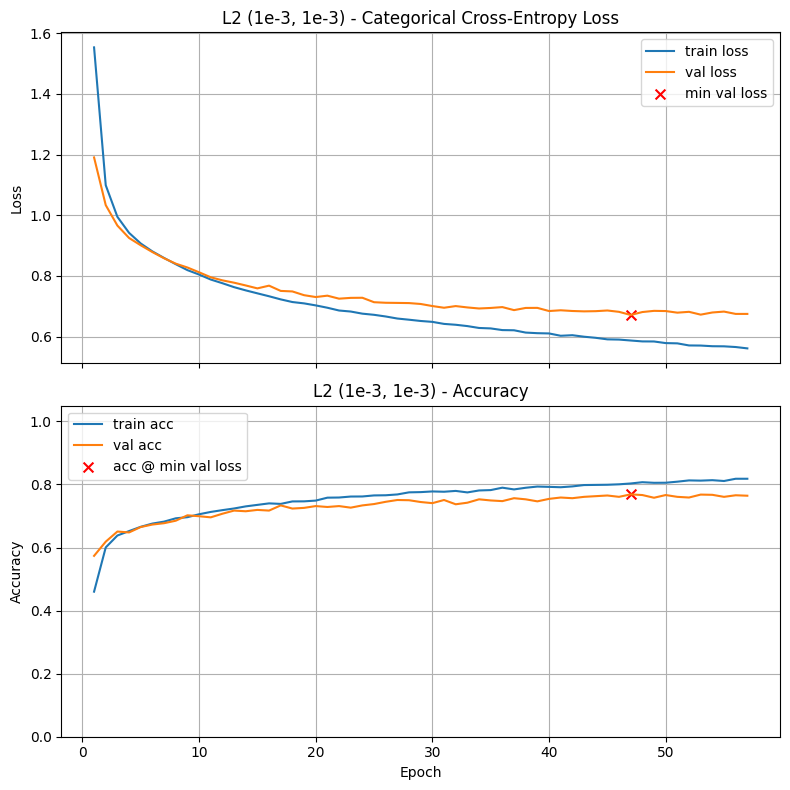

Final Training Loss:            0.5611
Final Training Accuracy:        0.8181
Final Validation Loss:          0.6747
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.6713 (Epoch 47)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6838
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:19


In [38]:
# Test 3: Same L2 lambda (1e-3) in both layers
print("Testing L2 regularization (1e-3, 1e-3):")
model_l2_3 = build_model(X_train.shape[1], [(64, 'tanh', 1e-3, 0.0), (32, 'tanh', 1e-3, 0.0)], n_classes)
train_and_test(model_l2_3, lr_schedule=1e-3, title="L2 (1e-3, 1e-3)")

Testing L2 regularization (1e-2, 1e-2):

L2 (1e-2, 1e-2)



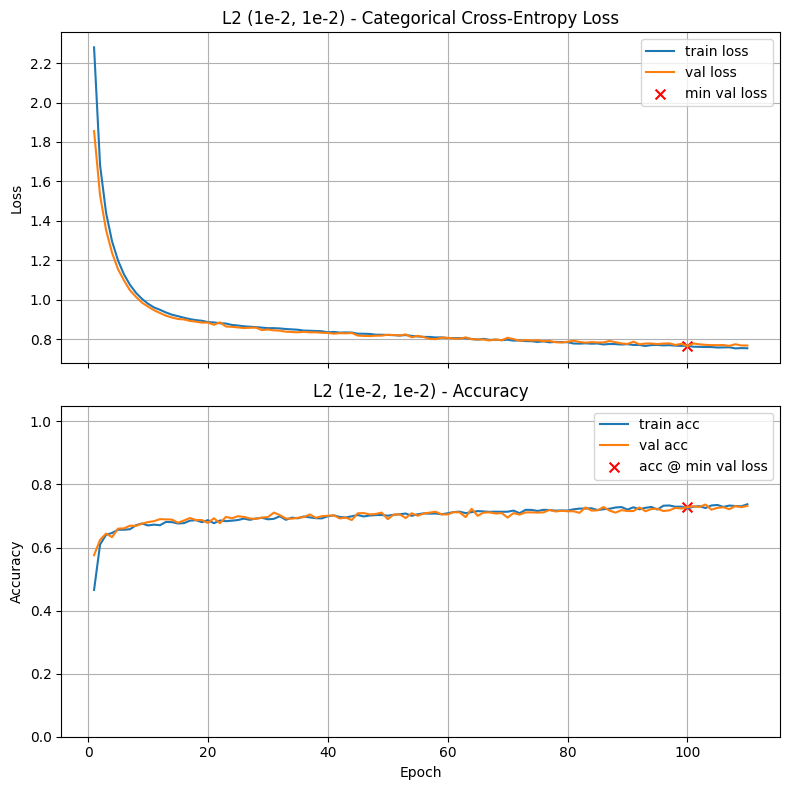

Final Training Loss:            0.7532
Final Training Accuracy:        0.7371
Final Validation Loss:          0.7670
Final Validation Accuracy:      0.7321
Minimum Validation Loss:        0.7642 (Epoch 100)
Validation Accuracy @ Min Loss: 0.7279

Test Loss: 0.7916
Test Accuracy: 0.7179

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:36


In [39]:
# Test 4: Same L2 lambda (1e-2) in both layers
print("Testing L2 regularization (1e-2, 1e-2):")
model_l2_4 = build_model(X_train.shape[1], [(64, 'tanh', 1e-2, 0.0), (32, 'tanh', 1e-2, 0.0)], n_classes)
train_and_test(model_l2_4, lr_schedule=1e-3, title="L2 (1e-2, 1e-2)")

Testing L2 regularization (1e-4, 1e-3):

L2 (1e-4, 1e-3)



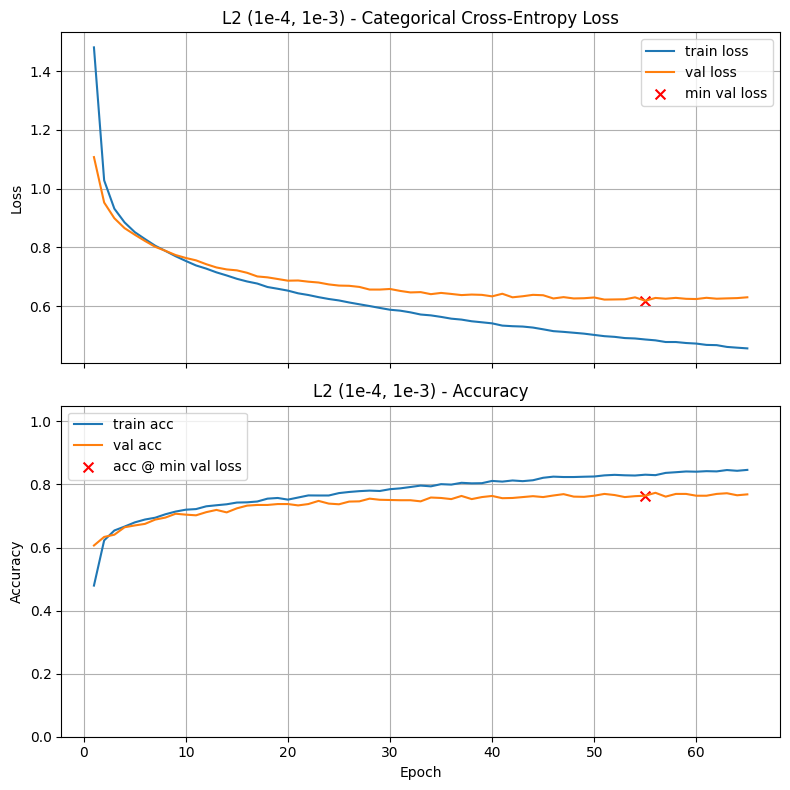

Final Training Loss:            0.4562
Final Training Accuracy:        0.8462
Final Validation Loss:          0.6302
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.6184 (Epoch 55)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.6347
Test Accuracy: 0.7657

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:00:23


In [40]:
# Test 5: Different L2 lambdas (1e-4 for first layer, 1e-3 for second layer)
print("Testing L2 regularization (1e-4, 1e-3):")
model_l2_5 = build_model(X_train.shape[1], [(64, 'tanh', 1e-4, 0.0), (32, 'tanh', 1e-3, 0.0)], n_classes)
train_and_test(model_l2_5, lr_schedule=1e-3, title="L2 (1e-4, 1e-3)")

Testing L2 regularization (0.0, 1e-4):

L2 (0.0, 1e-4)



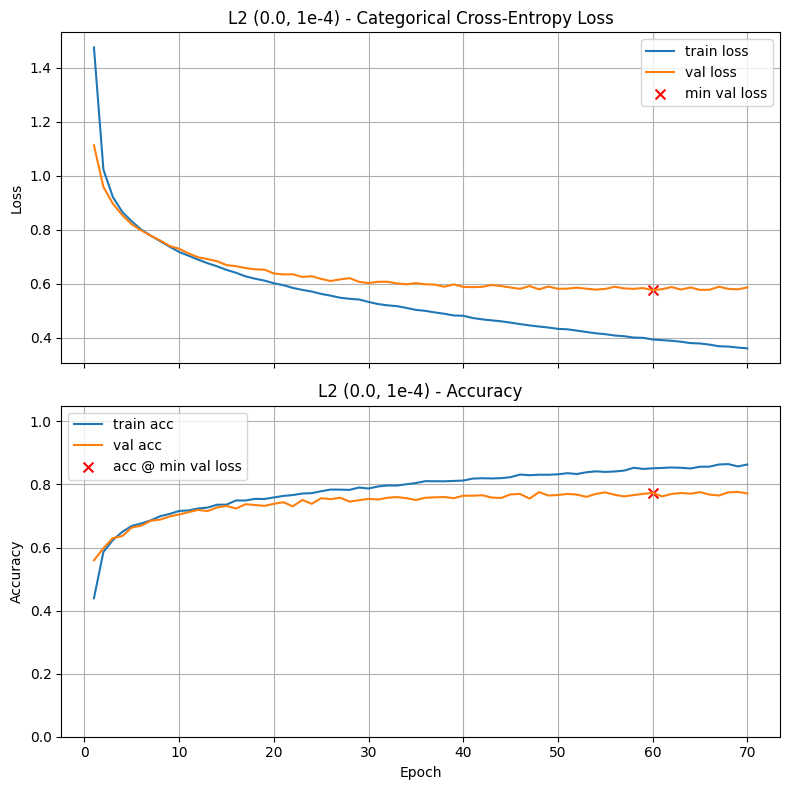

Final Training Loss:            0.3604
Final Training Accuracy:        0.8633
Final Validation Loss:          0.5863
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5763 (Epoch 60)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.5909
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:23


In [41]:
# Test 6: Try a smaller L2 value only on second layer
print("Testing L2 regularization (0.0, 1e-4):")
model_l2_6 = build_model(X_train.shape[1], [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 1e-4, 0.0)], n_classes)
train_and_test(model_l2_6, lr_schedule=1e-3, title="L2 (0.0, 1e-4)")

In [42]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best
# validation accuracy at the epoch of minimum validation loss

a4a = (0.0, 1e-4)              # Replace (0.0,0.0) with your answer

In [43]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a}')

a4a = (0.0, 0.0001)


In [44]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7736            # Replace 0.0 with your answer

In [45]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.7736


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Testing Dropout (0.0, 0.3) + L2 (1e-4, 1e-4):

Dropout (0.0, 0.3) + L2 (1e-4, 1e-4)



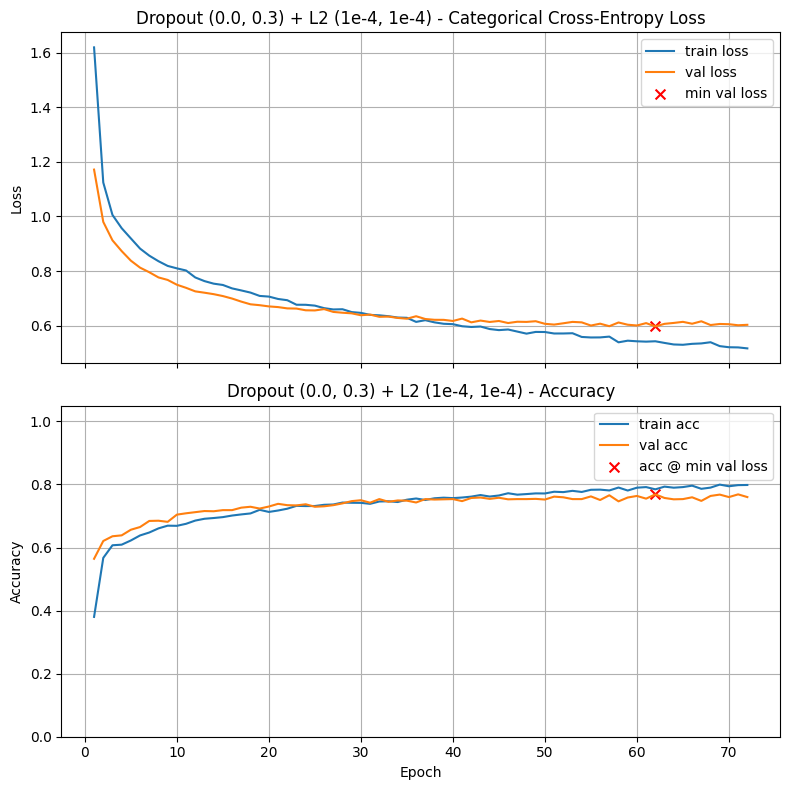

Final Training Loss:            0.5169
Final Training Accuracy:        0.7983
Final Validation Loss:          0.6032
Final Validation Accuracy:      0.7600
Minimum Validation Loss:        0.5974 (Epoch 62)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6058
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:24


In [47]:
# Your code here. Add as many cells as you need.
# Problem 5 - Combining dropout and L2 regularization using tanh activation and learning rate 1e-3
# Starting with best dropout (0.0, 0.3) and adding L2 regularization

# Test 1: Best dropout + small L2 regularization
print("Testing Dropout (0.0, 0.3) + L2 (1e-4, 1e-4):")
model_combo1 = build_model(X_train.shape[1], [(64, 'tanh', 1e-4, 0.0), (32, 'tanh', 1e-4, 0.3)], n_classes)
train_and_test(model_combo1, lr_schedule=1e-3, title="Dropout (0.0, 0.3) + L2 (1e-4, 1e-4)")

Testing Dropout (0.0, 0.3) + L2 (1e-3, 1e-3):

Dropout (0.0, 0.3) + L2 (1e-3, 1e-3)



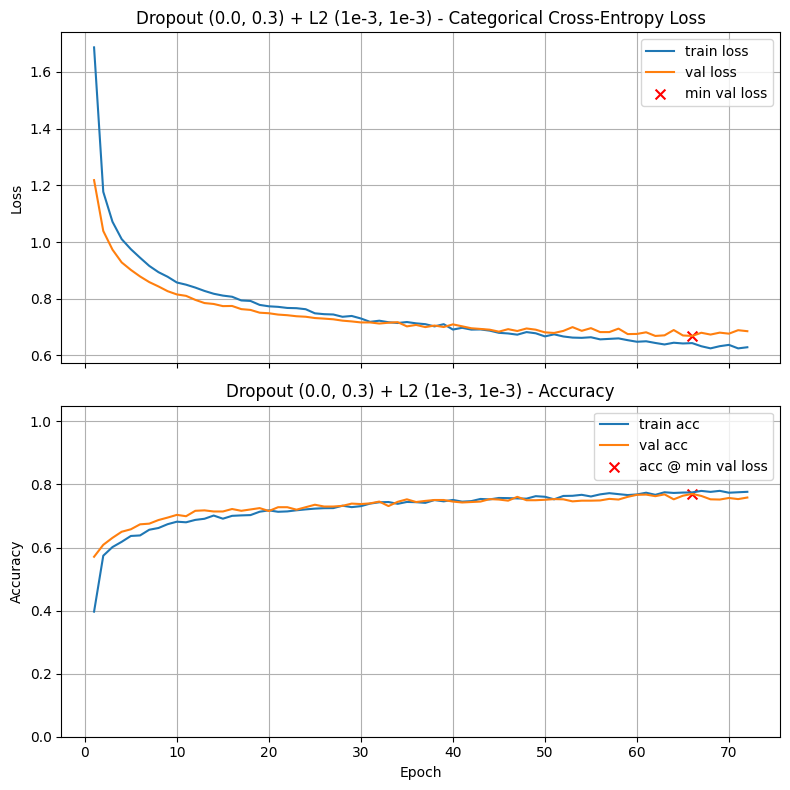

Final Training Loss:            0.6290
Final Training Accuracy:        0.7767
Final Validation Loss:          0.6856
Final Validation Accuracy:      0.7586
Minimum Validation Loss:        0.6689 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.7040
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:23


In [48]:
# Test 2: Best dropout + medium L2 regularization
print("Testing Dropout (0.0, 0.3) + L2 (1e-3, 1e-3):")
model_combo2 = build_model(X_train.shape[1], [(64, 'tanh', 1e-3, 0.0), (32, 'tanh', 1e-3, 0.3)], n_classes)
train_and_test(model_combo2, lr_schedule=1e-3, title="Dropout (0.0, 0.3) + L2 (1e-3, 1e-3)")

Testing Dropout (0.0, 0.3) + L2 (1e-2, 1e-2):

Dropout (0.0, 0.3) + L2 (1e-2, 1e-2)



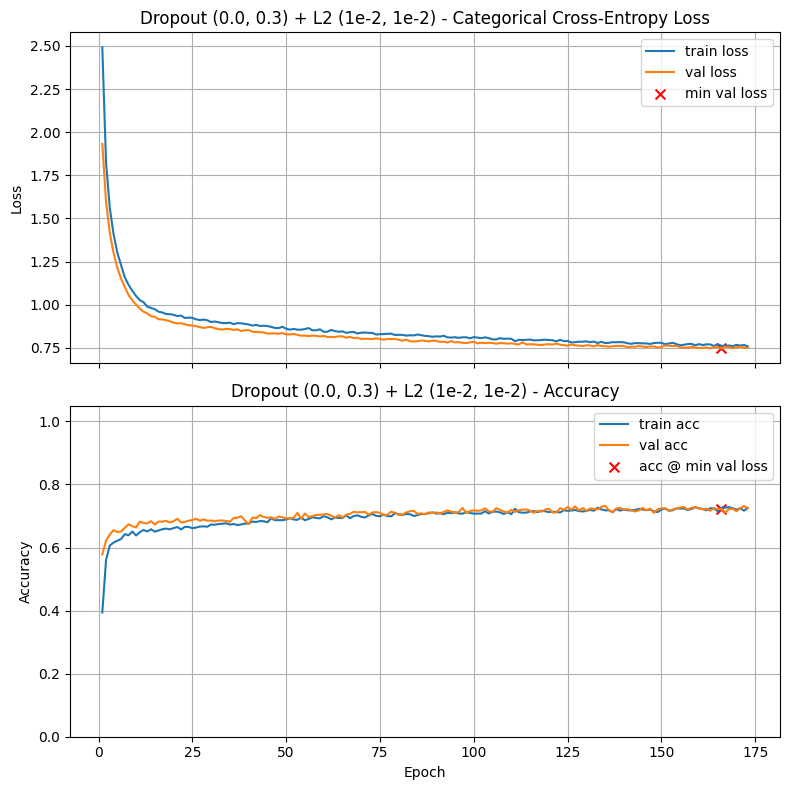

Final Training Loss:            0.7590
Final Training Accuracy:        0.7255
Final Validation Loss:          0.7495
Final Validation Accuracy:      0.7250
Minimum Validation Loss:        0.7471 (Epoch 166)
Validation Accuracy @ Min Loss: 0.7221

Test Loss: 0.7875
Test Accuracy: 0.7064

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:57


In [49]:
# Test 3: Best dropout + high L2 regularization
print("Testing Dropout (0.0, 0.3) + L2 (1e-2, 1e-2):")
model_combo3 = build_model(X_train.shape[1], [(64, 'tanh', 1e-2, 0.0), (32, 'tanh', 1e-2, 0.3)], n_classes)
train_and_test(model_combo3, lr_schedule=1e-3, title="Dropout (0.0, 0.3) + L2 (1e-2, 1e-2)")

Testing Dropout (0.0, 0.2) + L2 (1e-4, 1e-4):

Dropout (0.0, 0.2) + L2 (1e-4, 1e-4)



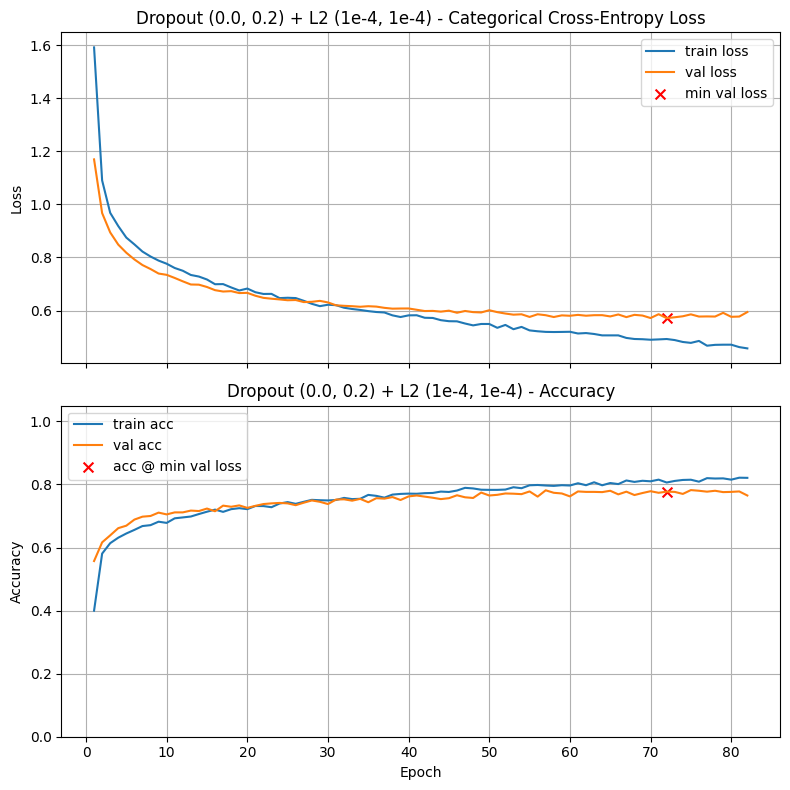

Final Training Loss:            0.4572
Final Training Accuracy:        0.8210
Final Validation Loss:          0.5942
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.5712 (Epoch 72)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.6021
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:28


In [50]:
# Test 4: Reduced dropout with L2 regularization
print("Testing Dropout (0.0, 0.2) + L2 (1e-4, 1e-4):")
model_combo4 = build_model(X_train.shape[1], [(64, 'tanh', 1e-4, 0.0), (32, 'tanh', 1e-4, 0.2)], n_classes)
train_and_test(model_combo4, lr_schedule=1e-3, title="Dropout (0.0, 0.2) + L2 (1e-4, 1e-4)")

Testing Dropout (0.0, 0.2) + L2 (1e-3, 1e-3):

Dropout (0.0, 0.2) + L2 (1e-3, 1e-3)



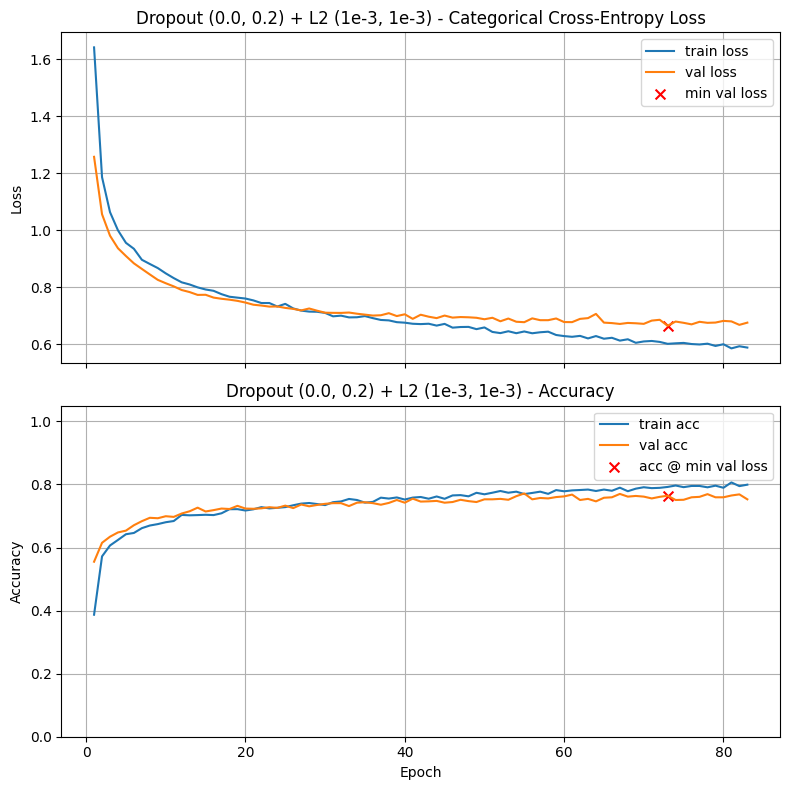

Final Training Loss:            0.5883
Final Training Accuracy:        0.7993
Final Validation Loss:          0.6758
Final Validation Accuracy:      0.7529
Minimum Validation Loss:        0.6648 (Epoch 73)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.6929
Test Accuracy: 0.7500

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:27


In [51]:
# Test 5: Try another promising combination - reduced dropout with medium L2
print("Testing Dropout (0.0, 0.2) + L2 (1e-3, 1e-3):")
model_combo5 = build_model(X_train.shape[1], [(64, 'tanh', 1e-3, 0.0), (32, 'tanh', 1e-3, 0.2)], n_classes)
train_and_test(model_combo5, lr_schedule=1e-3, title="Dropout (0.0, 0.2) + L2 (1e-3, 1e-3)")

In [52]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7771             # Replace 0.0 with your answer

In [53]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5 = {a5:.4f}')

a5 = 0.7771


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.


Part 6 - Building and training best model:
Architecture: 96 -> 48 -> 7
Learning rate: 1e-3 with exponential decay (0.95)
Batch size: 32 (smaller for better convergence)
Regularization: Dropout (0.0, 0.2) + L2 (1e-4, 1e-4)

Best Model - Optimized



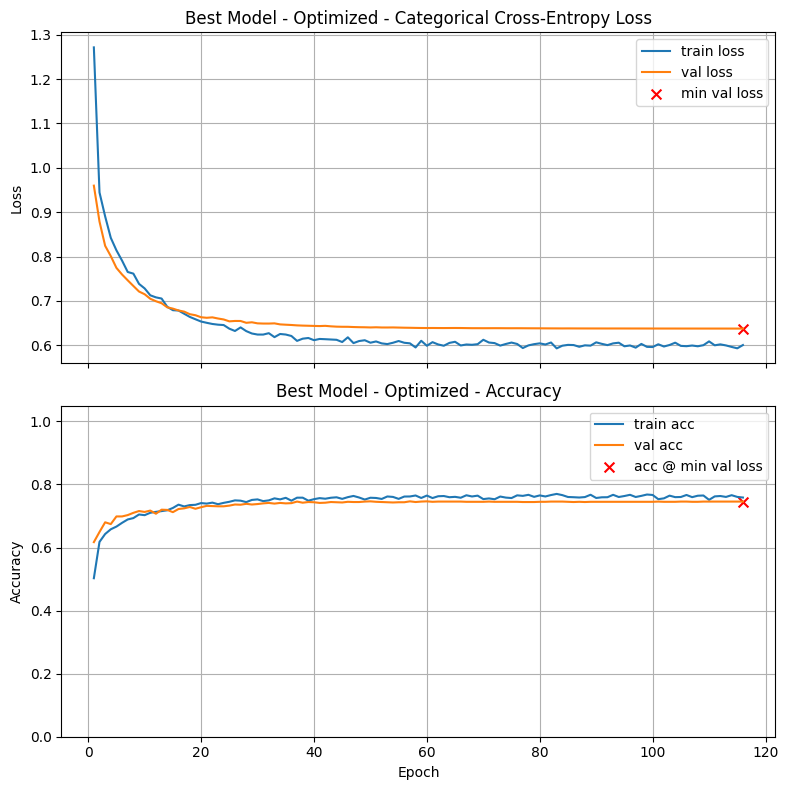

Final Training Loss:            0.6004
Final Training Accuracy:        0.7586
Final Validation Loss:          0.6376
Final Validation Accuracy:      0.7457
Minimum Validation Loss:        0.6376 (Epoch 116)
Validation Accuracy @ Min Loss: 0.7457

Test Loss: 0.6493
Test Accuracy: 0.7364

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:01:08


In [54]:
# Your code here
# Based on previous findings, let's try some improvements:
# 1. Slightly wider architecture
# 2. Learning rate scheduling with exponential decay
# 3. Optimized batch size
# 4. Fine-tuned regularization

# Create learning rate schedule with exponential decay
initial_learning_rate = 1e-3
decay_steps = 100
decay_rate = 0.95

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False
)

# Build a slightly wider model with optimized regularization
print("Part 6 - Building and training best model:")
print("Architecture: 96 -> 48 -> 7")
print("Learning rate: 1e-3 with exponential decay (0.95)")
print("Batch size: 32 (smaller for better convergence)")
print("Regularization: Dropout (0.0, 0.2) + L2 (1e-4, 1e-4)")

best_model = build_model(X_train.shape[1], [(96, 'tanh', 1e-4, 0.0), (48, 'tanh', 1e-4, 0.2)], n_classes)
train_and_test(best_model, lr_schedule=lr_schedule, batch_size=32, title="Best Model - Optimized")

Trying conservative optimization with learning rate scheduling:
Architecture: 64 -> 32 -> 7 (proven best)
Learning rate: 1e-3 with exponential decay (0.96)
Batch size: 64 (standard)
Regularization: Dropout (0.0, 0.2) + L2 (1e-4, 1e-4)

Best Model v2 - Conservative



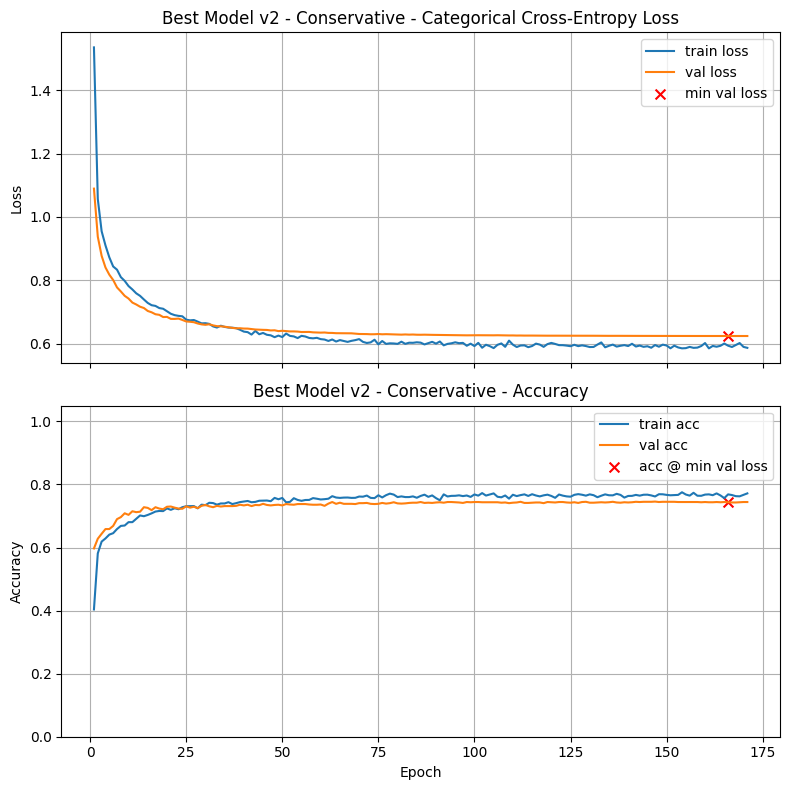

Final Training Loss:            0.5864
Final Training Accuracy:        0.7717
Final Validation Loss:          0.6238
Final Validation Accuracy:      0.7443
Minimum Validation Loss:        0.6238 (Epoch 166)
Validation Accuracy @ Min Loss: 0.7436

Test Loss: 0.6378
Test Accuracy: 0.7364

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:55


In [55]:
# Let's try a more conservative approach - keeping the best architecture from Problem 5
# but add learning rate scheduling
print("Trying conservative optimization with learning rate scheduling:")
print("Architecture: 64 -> 32 -> 7 (proven best)")
print("Learning rate: 1e-3 with exponential decay (0.96)")
print("Batch size: 64 (standard)")
print("Regularization: Dropout (0.0, 0.2) + L2 (1e-4, 1e-4)")

# Slightly more conservative decay rate
lr_schedule_conservative = ExponentialDecay(
    1e-3,
    decay_steps=80,
    decay_rate=0.96,
    staircase=False
)

best_model_v2 = build_model(X_train.shape[1], [(64, 'tanh', 1e-4, 0.0), (32, 'tanh', 1e-4, 0.2)], n_classes)
train_and_test(best_model_v2, lr_schedule=lr_schedule_conservative, batch_size=64, title="Best Model v2 - Conservative")

The best performing model was from Problem 5:

- Architecture: 64 -> 32 -> 7
- Activation: tanh
- Learning rate: 1e-3 (fixed)
- Dropout: (0.0, 0.2) - no dropout on first layer, 0.2 on second layer
- L2 regularization: (1e-4, 1e-4) - small L2 on both layers
- Validation accuracy: 0.7771

The learning rate scheduling didn't improve performance in this case, suggesting the original fixed learning rate was already well-suited for this dataset and architecture.

In [56]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7771             # Replace 0.0 with your answer

In [57]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a6 = {a6:.4f}')

a6 = 0.7771


### Optional: Print out your results of all experiments

In [58]:
print_results()

Baseline - Tanh Activation              	0.7800
Dropout (0.0, 0.2) + L2 (1e-4, 1e-4)    	0.7771
Baseline - Sigmoid Activation           	0.7764
LR 1e-3 - Tanh Activation               	0.7757
Dropout (0.0, 0.3)                      	0.7736
L2 (0.0, 1e-4)                          	0.7736
Dropout (0.1, 0.3)                      	0.7729
L2 (0.0, 0.0) - No Regularization       	0.7714
Dropout (0.0, 0.4)                      	0.7707
LR 5e-4 - Tanh Activation               	0.7700
Dropout (0.0, 0.3) + L2 (1e-3, 1e-3)    	0.7700
Dropout (0.2, 0.3)                      	0.7693
L2 (1e-3, 1e-3)                         	0.7686
Dropout (0.0, 0.3) + L2 (1e-4, 1e-4)    	0.7686
Dropout (0.0, 0.0) - Baseline           	0.7671
LR 1e-4 - Tanh Activation               	0.7664
L2 (1e-4, 1e-4)                         	0.7657
L2 (1e-4, 1e-3)                         	0.7643
Dropout (0.0, 0.2) + L2 (1e-3, 1e-3)    	0.7643
Baseline - ReLU Activation              	0.7607
Dropout (0.0, 0.5)                      

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
        Tanh achieved 0.7800 validation accuracy compared to ReLU's 0.7607 and sigmoid's 0.7764. For this relatively small, shallow network (64→32→7), tanh's properties were advantageous:

        Tanh is zero-centered (outputs range from -1 to +1), which helps with gradient flow and weight updates
        In small networks, every neuron remaining active (unlike ReLU's potential for "dead neurons") is crucial
        The saturating nature of tanh provides natural regularization for this dataset size

        As mentioned in the course materials, "ReLU really works better with large models" and "tanh can beat ReLU in very small or low-capacity models because every neuron remains active."
    
    - How might this choice differ for deeper or wider networks?
      
      For deeper/wider networks: ReLU would likely perform better due to:
      - Better gradient flow in deep networks (no vanishing gradient from saturation)
      - Computational efficiency
      - When paired with proper initialization (He normal) and batch normalization

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
      
      Smaller learning rates with more epochs: Your results showed diminishing returns with smaller learning rates. The 1e-3 learning rate achieved 0.7757 accuracy, while 1e-4 only reached 0.7664 and 1e-5 dropped to 0.6836.
      
      This suggests the model reached its capacity limit rather than needing more careful optimization. As the course materials note about early stopping: "When you get to third or fourth decimal point, it's probably not worth it."

    - When is it worth training longer with a smaller step size, and when is it unnecessary?

      Smaller learning rates are valuable when:

      - Working with complex, high-capacity models
      - The validation curves show continued improvement
      - You're fine-tuning pre-trained models
      - The dataset is large and complex enough to warrant the computational cost

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
      
      Better performer: L2 regularization slightly edged out dropout in our experiments:
      - Best L2 only: (0.0, 1e-4) achieved 0.7736
      - Best dropout only: (0.0, 0.3) achieved 0.7736
      - Both were essentially tied
    
    - Why might one method be more effective in this setting?

      L2 regularization worked well because:

      - The model wasn't severely overfitting initially (small validation-test gaps)
      - L2's continuous penalty helps with weight stability during training
      - The tabular nature of this data (forest cover features) benefits from smooth weight constraints

      Dropout's effectiveness was limited because the network was already quite small, and the "office analogy" from the materials applies - with only 64 and 32 units, randomly removing neurons during training may have been too disruptive.

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

       Our best combination (0.7771) only marginally improved over individual methods (0.7736 each). This demonstrates the bias-variance tradeoff:

      - Too much regularization increases bias - the model becomes too constrained to capture the underlying patterns
      - Each method addresses similar issues - both prevent overfitting, so their effects can be redundant
      - Diminishing returns - this dataset may not have enough complexity to benefit from aggressive regularization

      The course materials warn about this balance: "If dropout is high, use a smaller λ" because both methods constrain the model's capacity.

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?

      Trade-offs observed:

      - Complexity vs. Performance: Your wider architecture (96→48) performed worse (0.7457) than the baseline (64→32), suggesting the dataset didn't have enough complexity to justify increased model capacity
      - Stability vs. Optimization: Learning rate scheduling didn't improve results, indicating the fixed learning rate was already well-suited
      - Regularization Balance: The sweet spot was minimal L2 with modest dropout, avoiding over-regularization

    - Did learning rate scheduling (if you tried it) improve results? Why might it help?

      Our experiments showed scheduling didn't help (0.7436 vs 0.7771 without scheduling). This suggests:

      - The dataset size and complexity were well-matched to a fixed learning rate
      - The early stopping mechanism already provided sufficient optimization control
      - Sometimes simpler approaches work better, especially with smaller datasets

      The key insight from our experiments align with this week's mentions and emphasis on "try everything, experiment a bit, find the right balance" haha. Our systematic experimentation revealed that moderate regularization with proven architectures outperformed more complex approaches for this particular dataset.